In [2]:
!pip install pyLDAvis
import pandas as pd
import numpy as np
import nltk
nltk.download('wordnet')
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from gensim import corpora, models
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 64.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 104.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 34.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cupy-cuda11x 11.0.0 requires numpy<1.26,>=1.20, but you have numpy 1.26.0 which is incompatible.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.1.1 which is incompatible.
numba 0.56.

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
data = pd.read_csv('/content/Reviews.csv', encoding='utf-8')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
data.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [34]:
df.isna().sum()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text    0
dtype: int64

In [6]:
np.random.seed(51)
df = data[['Text']].sample(n = 10005)
test = df[10000:10005]
df = df[:10000]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
data.shape, df.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


((34192, 10), (10000, 1))

In [8]:
df = df.reset_index(drop=True)
test = test.reset_index(drop=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Preprocessing**

In [9]:
def lemmatize_stemming(text):
    stemmer = SnowballStemmer('english')
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
doc_sample = df['Text'][0]

print('original text: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized text: ')
print(preprocess(doc_sample))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


original text: 
['This', 'is', 'a', 'tasty', 'low', 'cal', 'snack', 'and', 'the', 'single', 'serve', 'bags', 'are', 'good', 'for', 'those', 'who', "won't", 'rest', 'until', 'the', 'bag', 'is', 'empty.', '', 'If', 'you', 'need', 'to', 'watch', 'your', 'sodium', 'this', 'is', 'not', 'a', 'low', 'sodium', 'food.', '', 'The', 'Jalapeno', 'is', 'spicy', 'without', 'burning', 'your', 'tongue', 'and', 'lips.']


 tokenized and lemmatized text: 
['tasti', 'snack', 'singl', 'serv', 'bag', 'good', 'rest', 'need', 'watch', 'sodium', 'sodium', 'food', 'jalapeno', 'spici', 'burn', 'tongu', 'lip']


In [11]:
processed_text = df['Text'].map(preprocess)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
processed_text[:10]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0    [tasti, snack, singl, serv, bag, good, rest, n...
1    [tough, review, food, cat, ingredi, qualiti, c...
2             [charg, decid, keurig, cup, half, price]
3    [switch, orang, tangerin, look, promis, juic, ...
4    [love, treat, german, shepherd, think, treat, ...
5                  [purchas, past, enjoy, flavor, bad]
6    [great, quick, snack, rais, blood, sugar, leve...
7    [love, flavor, zatarain, love, cook, cajun, st...
8    [wit, hypoallergen, food, final, heartrend, tr...
9    [popchip, great, snack, altern, regular, chip,...
Name: Text, dtype: object

**EDA**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


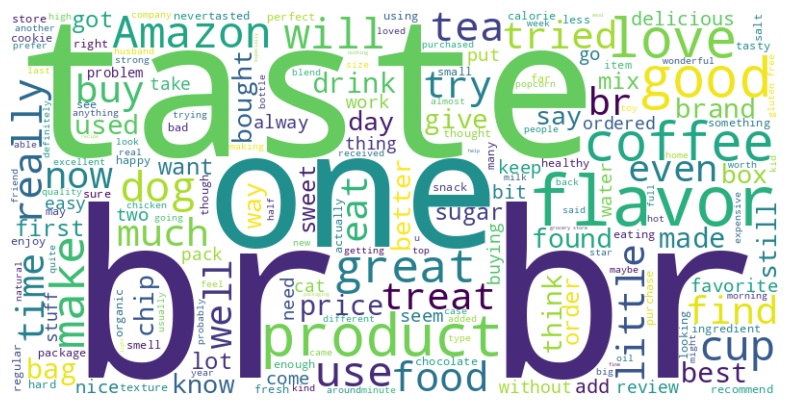

In [37]:
!pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# Combining all text into a single string
text_combined = ' '.join(df['Text'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [41]:
import nltk
from nltk.tokenize import word_tokenize  # Import the word_tokenize function from NLTK

# Ensure that NLTK data is downloaded (if not already downloaded)
nltk.download('punkt')

# Top N Words
word_tokens = word_tokenize(' '.join(df['Text']))
from nltk.probability import FreqDist
freq_dist = FreqDist(word_tokens)
top_n_words = freq_dist.most_common(20)
print("Top 20 Words:")
for word, freq in top_n_words:
    print(f"{word}: {freq}")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Top 20 Words:
.: 41720
,: 29797
the: 28738
I: 28180
and: 21687
a: 20319
to: 17178
it: 14847
of: 13765
is: 12772
>: 11984
<: 11966
/: 11435
br: 11407
for: 9194
this: 8964
in: 8820
!: 7649
that: 7351
my: 6222


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


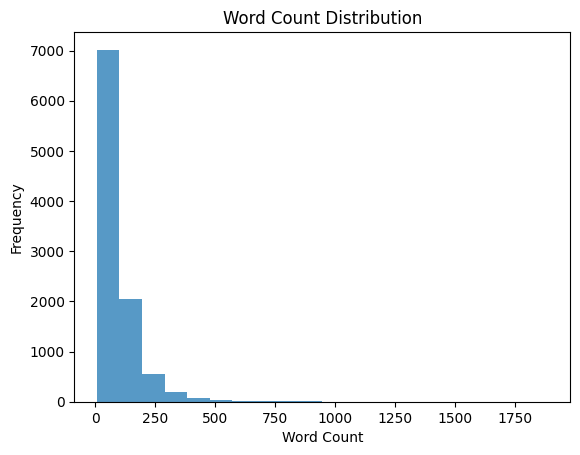

In [42]:
## getting word count
# Word Count Distribution
df['word_count'] = df['Text'].apply(lambda x: len(word_tokenize(x)))
plt.hist(df['word_count'], bins=20, alpha=0.75)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Word Count Distribution')
plt.show()

**BOW in dataset**

In [13]:
dictionary = gensim.corpora.Dictionary(processed_text)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
      break

0 bag
1 burn
2 food
3 good
4 jalapeno
5 lip
6 need
7 rest
8 serv
9 singl
10 snack


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
bow_corpus = [dictionary.doc2bow(text) for text in processed_text]
bow_corpus[10]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(64, 1), (75, 1), (84, 1), (90, 1), (129, 1), (202, 1), (203, 1), (204, 1)]

In [18]:
bow_doc_10 = bow_corpus[10]

for i in range(len(bow_doc_10)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_10[i][0],
                                                     dictionary[bow_doc_10[i][0]],
                                                     bow_doc_10[i][1]))

Word 64 ("think") appears 1 time.
Word 75 ("great") appears 1 time.
Word 84 ("product") appears 1 time.
Word 90 ("treat") appears 1 time.
Word 129 ("best") appears 1 time.
Word 202 ("breath") appears 1 time.
Word 203 ("clean") appears 1 time.
Word 204 ("teeth") appears 1 time.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**TF-IDF**

In [19]:
tfidf = models.TfidfModel(bow_corpus)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
corpus_tfidf = tfidf[bow_corpus]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
from pprint import pprint

for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.1805717728735798),
 (1, 0.2450617356245127),
 (2, 0.1160520476407732),
 (3, 0.07329564136078062),
 (4, 0.31294114750653795),
 (5, 0.35804182031244663),
 (6, 0.1491833094820095),
 (7, 0.23820803245298597),
 (8, 0.18550205170537667),
 (9, 0.22929041999600508),
 (10, 0.1625366688034461),
 (11, 0.4947782067005662),
 (12, 0.2175709648608475),
 (13, 0.17372014179358472),
 (14, 0.30305923599540335),
 (15, 0.23622860742006577)]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**LDA using BOW**

In [22]:
lda_model_bow = gensim.models.ldamodel.LdaModel(bow_corpus, num_topics=10, id2word=dictionary, passes=4)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
for idx, topic in lda_model_bow.print_topics(-1):
    print('Topic: {} \nWords: {} \n\n'.format(idx, topic))

Topic: 0 
Words: 0.044*"drink" + 0.039*"sugar" + 0.038*"tast" + 0.028*"like" + 0.027*"flavor" + 0.027*"water" + 0.022*"juic" + 0.019*"sweet" + 0.012*"soda" + 0.011*"fruit" 


Topic: 1 
Words: 0.058*"food" + 0.023*"like" + 0.018*"ingredi" + 0.017*"organ" + 0.014*"cat" + 0.014*"can" + 0.012*"milk" + 0.011*"good" + 0.011*"babi" + 0.011*"brand" 


Topic: 2 
Words: 0.029*"product" + 0.022*"free" + 0.017*"tast" + 0.016*"bread" + 0.016*"gluten" + 0.015*"great" + 0.015*"good" + 0.013*"syrup" + 0.012*"amazon" + 0.010*"like" 


Topic: 3 
Words: 0.094*"coffe" + 0.033*"flavor" + 0.028*"tast" + 0.023*"like" + 0.017*"chocol" + 0.016*"good" + 0.016*"roast" + 0.012*"cup" + 0.012*"tri" + 0.012*"strong" 


Topic: 4 
Words: 0.037*"product" + 0.029*"order" + 0.018*"great" + 0.017*"price" + 0.016*"ship" + 0.014*"time" + 0.012*"amazon" + 0.012*"packag" + 0.011*"arriv" + 0.011*"purchas" 


Topic: 5 
Words: 0.032*"amazon" + 0.028*"store" + 0.020*"price" + 0.016*"local" + 0.016*"product" + 0.012*"good" + 0.010

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Coherence Score**

In [24]:
coherence_model_bow = CoherenceModel(model=lda_model_bow, texts=processed_text, dictionary=dictionary, coherence='c_v')
coherence_bow = coherence_model_bow.get_coherence()
print('\nCoherence Score: ', coherence_bow)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Coherence Score:  0.4590765752366016


**LDA using TF-IDF**

In [28]:
lda_model_tfidf = gensim.models.ldamodel.LdaModel(corpus_tfidf, num_topics=10, id2word=dictionary, passes=4)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} \nWord: {} \n\n'.format(idx, topic))

Topic: 0 
Word: 0.040*"coffe" + 0.012*"flavor" + 0.010*"cup" + 0.010*"tast" + 0.010*"roast" + 0.009*"drink" + 0.008*"strong" + 0.008*"like" + 0.008*"brew" + 0.007*"blend" 


Topic: 1 
Word: 0.019*"chip" + 0.008*"snack" + 0.008*"tast" + 0.008*"flavor" + 0.007*"good" + 0.007*"great" + 0.007*"gluten" + 0.007*"salt" + 0.007*"love" + 0.007*"like" 


Topic: 2 
Word: 0.018*"drink" + 0.017*"juic" + 0.016*"sugar" + 0.013*"soda" + 0.012*"sweet" + 0.012*"carbon" + 0.011*"tast" + 0.010*"flavor" + 0.009*"fruit" + 0.009*"orang" 


Topic: 3 
Word: 0.022*"syrup" + 0.021*"pumpkin" + 0.018*"mapl" + 0.014*"almond" + 0.013*"grade" + 0.013*"oatmeal" + 0.012*"dent" + 0.012*"cooki" + 0.011*"can" + 0.010*"organ" 


Topic: 4 
Word: 0.016*"price" + 0.014*"store" + 0.012*"amazon" + 0.011*"local" + 0.011*"ship" + 0.010*"great" + 0.010*"product" + 0.009*"order" + 0.008*"love" + 0.008*"plant" 


Topic: 5 
Word: 0.021*"peanut" + 0.020*"greeni" + 0.018*"teeth" + 0.017*"butter" + 0.011*"breath" + 0.011*"love" + 0.009*

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Coherence Score**

In [30]:
coherence_model_tfidf = CoherenceModel(model=lda_model_tfidf, texts=processed_text, dictionary=dictionary, coherence='c_v')
coherence_tfidf = coherence_model_tfidf.get_coherence()
print('\nCoherence Score: ', coherence_tfidf)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Coherence Score:  0.4393152386237345


In [32]:
unseen_document = test['Text'][0]
bow_vector = dictionary.doc2bow(preprocess(unseen_document))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
lda_model_bow[bow_vector]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(6, 0.34992298), (9, 0.6214965)]